In [1]:
# Notebook for training and testing a Player in Pokemon Showdown using Monte Carlo 

In [1]:
"""
Max Player Performance: 57,8 % 
------
neptune
Action space: 4 moves + 5 switches
poke-env installed in C:\\Users\\-\\anaconda3\\envs\\poke_env\\lib\\site-packages
"""


'\nMax Player Performance: 57,8 % \n------\nneptune\nAction space: 4 moves + 5 switches\npoke-env installed in C:\\Users\\-\\anaconda3\\envs\\poke_env\\lib\\site-packages\n'

In [20]:
from poke_env.player.random_player import RandomPlayer 



In [1]:
# Imports

import numpy as np

import sys
from gym import spaces
import asyncio
import time

from collections import defaultdict

from src.playerMC import Player as PlayerMC

from poke_env.player.player import Player 
#from poke_env.player.random_player import RandomPlayer

from poke_env.environment.abstract_battle import AbstractBattle

import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
#loop = asyncio.get_event_loop()
use_neptune = True
if use_neptune:
    import neptune.new as neptune
    run = neptune.init(project='leolellisr/rl-pokeenv',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==')


https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-86
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [2]:
def name_to_id(name):
    if(name == 'venusaur'): return 0
    if(name == 'pikachuoriginal'): return 1 
    if(name == 'tauros'): return 2 
    if(name == 'sirfetchd'): return 3 
    if(name == 'blastoise'): return 4 
    if(name == 'charizard'): return 5 
    if(name == 'eevee'): return 0
    if(name == 'vaporeon'): return 1 
    if(name == 'leafeon'): return 2 
    if(name == 'sylveon'): return 3 
    if(name == 'jolteon'): return 4 
    if(name == 'umbreon'): return 5     

In [3]:
class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        # If the player can attack, it will
        if battle.available_moves:
            # Finds the best move among available ones
            #print(battle.available_moves[0])
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)

        # If no attack is available, a random switch will be made
        else:
            return self.choose_random_move(battle)

In [4]:
class MCPlayer(PlayerMC):
    def choose_move(self, battle):
        # In the 1st state of all we don't append yet;
        # Other states: using previous state and action with actual reward (actual battle) 
        if self.previous_action != -10: self.episode.append((self.previous_state, self.previous_action, self.compute_reward(battle)))
            
        # Getting state s (-> embed battle)
        s = self.embed_battle(battle)
        # 1st move will be random wout policy    
        if(self.aux == 0):
            self.aux = 1
            action = np.random.choice(self.action_space)

        # Other moves have policy    
        else: action = np.random.choice(self.action_space, p=self.policy(s))

        # Saving action and state to append later. We can compute the reward only after the move    
        self.previous_action = action
        self.previous_state = s

        # Prints for debuging    
        #print(battle.available_moves)
        #print(f"Choosed action int: {action}")        
        #print("Return: ", self.policy(s))

        # Choose move according to action index
        if action == -1:
            return ForfeitBattleOrder()
        elif (
            action < 4
            and action < len(battle.available_moves)
            and not battle.force_switch
        ):
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)
        

    # the embed battle is our state
    # 10 factors: 4 moves base power, 4 moves multipliers, active pokemon and active opponent pokemon 
    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power or not available

        #print(active_pokemon)
        
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling 
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # how many pokemons have fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )

        # Final vector with 10 components
        #x = np.around(np.concatenate(
        #    [
        #         np.array([name_id]), moves_base_power,
        #        moves_dmg_multiplier,
        #        [remaining_mon_team, remaining_mon_opponent]
        #    ])
        #,decimals=2)
        state = list()
        #active_pokemon = [mon for mon in battle.team.values() if mon._active]
        #name_id = name_to_id(active_pokemon[0]._species)        
        state.append('{0:.2f}'.format(name_to_id(str(battle.active_pokemon).split(' ')[0])))
        state.append('{0:.2f}'.format(name_to_id(str(battle.opponent_active_pokemon).split(' ')[0])))    
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append('{0:.2f}'.format(remaining_mon_team))
        state.append('{0:.2f}'.format(remaining_mon_opponent))
        # Convert to string so we can use as hash
        return str(state)
    #' '.join(str(i) for i in x)
        

    # Computing rewards
    def reward_computing_helper(
        self,
        battle: AbstractBattle,
        *,
        fainted_value: float = 0.15, 
        hp_value: float = 0.15,      
        number_of_pokemons: int = 6,
        starting_value: float = 0.0,
        status_value: float = 0.15, 
        victory_value: float = 1.0
    ) -> float:
        
        # 1st compute
        if battle not in self._reward_buffer:
            self._reward_buffer[battle] = starting_value
        current_value = 0
        
        # Verify if pokemon have fainted or have status
        for mon in battle.team.values():
            current_value += mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value -= fainted_value
            elif mon.status is not None:
                current_value -= status_value

        current_value += (number_of_pokemons - len(battle.team)) * hp_value

        # Verify if opponent pokemon have fainted or have status
        for mon in battle.opponent_team.values():
            current_value -= mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value += fainted_value
            elif mon.status is not None:
                current_value += status_value

        current_value -= (number_of_pokemons - len(battle.opponent_team)) * hp_value

        # Verify if we won or lost
        if battle.won:
            current_value += victory_value
        elif battle.lost:
            current_value -= victory_value

        # Value to return
        to_return = current_value - self._reward_buffer[battle]
        self._reward_buffer[battle] = current_value
        #self.reward_per_battle.append(current_value)
        #print(self.reward_per_battle)
        if use_neptune: run[f'N0: {self.n0} gamma: {self.gamma} reward_buffer'].log(current_value)
        #run[f'N0: {self.n0} gamma: {self.gamma} reward returned'].log(to_return)
        return to_return
    
    
    # Calling reward_computing_helper
    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(            
            battle, fainted_value=2, hp_value=1, status_value=1, victory_value=15
        )

    # Battle (episode) has finished
    def _battle_finished_callback(self, battle):
        rewards = [reward for state,action,reward in self.episode]
        states = [state for state,action,reward in self.episode]
        actions = [action for state,action,reward in self.episode]
        t_array = range(len(self.episode)+1)
        #run[f'N0: {self.n0} gamma: {self.gamma} Gt'].log(returnGt)
        # Computing Q and N
        for idx, state in enumerate(states):
            action = actions[idx]
            if state not in self.visited_states:
                self.N[state][action] += 1
                #print(len(rewards[idx:]))
                #print(len(t_array[:(-idx-1)]))
                returnGt = sum([reward*pow(self.gamma, t) for reward, t in zip(rewards[idx:], t_array[:(-idx-1)])]) 

                # incremental update of Q value is more efficient than keeping a record of all rewards
                # and averaging after every new reward
                # step-size: 1./N[state][action]
                
                self.Q[state][action] += (1/self.N[state][action])*(returnGt-self.Q[state][action]) 
                #run[f'N0: {self.n0} gamma: {self.gamma} q_value'].log(self.Q[state][action])
                self.visited_states.append(state)
                
        self.visited_states = []
        self.episode = []
        if(self.aux == 1):
            self.aux == 0
            
        # Define new policy with updated Q and N
        self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
        if use_neptune: run[f'N0: {self.n0} gamma: {self.gamma} win_acc'].log(self.n_won_battles/len(self._reward_buffer))
        
# We evaluate the performance on mon_a against mon_b as its type advantage
"""
    def teampreview_performance(self, mon_a, mon_b):    
        a_on_b = b_on_a = -np.inf
        for type_ in mon_a.types:
            if type_:
                a_on_b = max(a_on_b, type_.damage_multiplier(*mon_b.types))
        # We do the same for mon_b over mon_a
        for type_ in mon_b.types:
            if type_:
                b_on_a = max(b_on_a, type_.damage_multiplier(*mon_a.types))
        # Our performance metric is the different between the two
        return a_on_b - b_on_a    
    
    # Teampreview (Before battle starts)
    def teampreview(self, battle):
        mon_performance = {}

        # For each of our pokemons
        for i, mon in enumerate(battle.team.values()):
            # We store their average performance against the opponent team
            mon_performance[i] = np.mean(
                [
                    self.teampreview_performance(mon, opp)
                    for opp in battle.opponent_team.values()
                ]
            )
        
        # We sort our mons by performance
        ordered_mons = sorted(mon_performance, key=lambda k: -mon_performance[k])
        
        # We start with the one we consider best overall
        # We use i + 1 as python indexes start from 0
        #  but showdown's indexes start from 1
        return "/team " + "".join([str(i + 1) for i in ordered_mons])
"""

'\n    def teampreview_performance(self, mon_a, mon_b):    \n        a_on_b = b_on_a = -np.inf\n        for type_ in mon_a.types:\n            if type_:\n                a_on_b = max(a_on_b, type_.damage_multiplier(*mon_b.types))\n        # We do the same for mon_b over mon_a\n        for type_ in mon_b.types:\n            if type_:\n                b_on_a = max(b_on_a, type_.damage_multiplier(*mon_a.types))\n        # Our performance metric is the different between the two\n        return a_on_b - b_on_a    \n    \n    # Teampreview (Before battle starts)\n    def teampreview(self, battle):\n        mon_performance = {}\n\n        # For each of our pokemons\n        for i, mon in enumerate(battle.team.values()):\n            # We store their average performance against the opponent team\n            mon_performance[i] = np.mean(\n                [\n                    self.teampreview_performance(mon, opp)\n                    for opp in battle.opponent_team.values()\n                

In [5]:
our_team = """
Pikachu-Original (M) @ Light Ball  
Ability: Static  
EVs: 252 Atk / 4 SpD / 252 Spe  
Adamant Nature  
- Volt Tackle  
- Nuzzle  
- Iron Tail  
- Knock Off  

Charizard @ Life Orb  
Ability: Solar Power  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Flamethrower  
- Dragon Pulse  
- Roost  
- Sunny Day  

Blastoise @ White Herb  
Ability: Torrent  
EVs: 4 Atk / 252 SpA / 252 Spe  
Mild Nature  
- Scald  
- Ice Beam  
- Earthquake  
- Shell Smash  

Venusaur @ Black Sludge  
Ability: Chlorophyll  
EVs: 252 SpA / 4 SpD / 252 Spe  
Modest Nature  
IVs: 0 Atk  
- Giga Drain  
- Sludge Bomb  
- Sleep Powder  
- Leech Seed  

Sirfetch’d @ Aguav Berry  
Ability: Steadfast  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Close Combat  
- Swords Dance  
- Poison Jab  
- Knock Off  

Tauros (M) @ Assault Vest  
Ability: Intimidate  
EVs: 252 Atk / 4 SpD / 252 Spe  
Adamant Nature  
- Double-Edge  
- Earthquake  
- Megahorn  
- Iron Head  
"""

In [6]:
op_team = """
Eevee @ Eviolite  
Ability: Adaptability  
EVs: 252 HP / 252 Atk / 4 SpD  
Jolly Nature  
- Quick Attack  
- Flail  
- Facade  
- Wish  

Vaporeon @ Leftovers  
Ability: Hydration  
EVs: 252 HP / 252 Def / 4 SpA  
Bold Nature  
IVs: 0 Atk  
- Scald  
- Shadow Ball  
- Toxic  
- Wish  

Sylveon @ Aguav Berry  
Ability: Pixilate  
EVs: 252 HP / 252 SpA / 4 SpD  
Modest Nature  
IVs: 0 Atk  
- Hyper Voice  
- Mystical Fire  
- Psyshock  
- Calm Mind  

Jolteon @ Assault Vest  
Ability: Quick Feet  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Thunderbolt  
- Hyper Voice  
- Volt Switch  
- Shadow Ball  

Leafeon @ Life Orb  
Ability: Chlorophyll  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Leaf Blade  
- Knock Off  
- X-Scissor  
- Swords Dance  

Umbreon @ Iapapa Berry  
Ability: Inner Focus  
EVs: 252 HP / 4 Atk / 252 SpD  
Careful Nature  
- Foul Play  
- Body Slam  
- Toxic  
- Wish  
"""

In [7]:
import os
import json
import re
from datetime import date
today = date.today()

In [8]:
directoryQ = r'S:\poke_env\dump\211029_40k\qvalues'
Q_array = []
for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)    
    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
    Q_array.append(Qjson)
    
directoryN = r'S:\poke_env\dump\211029_40k\nvalues'
N_array = []
for filenameN in os.listdir(directoryN):
    Njson_file = open(directoryN+'/'+filenameN,)
    Njson = json.load(Njson_file)
    for key in Njson:
        Njson[key] = np.array(Njson[key])
    N_array.append(Njson)

In [10]:
os.listdir(directoryQ)

['Q_QLearning_20211030_n_battles_40000_N0_00001_gamma_075_wining_427.json',
 'Q_QLearning_20211030_n_battles_40000_N0_0001_gamma_075_wining_4489.json',
 'Q_QLearning_20211030_n_battles_40000_N0_001_gamma_075_wining_4605.json']

In [11]:
# n0_range: N0 values that will be used in our policy function: epsilon = n0/(n0+np.sum(N[state]))
# n_battles: list of number of battles (episodes) that will be played.
"""

n0_range = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
gamma_range = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9]

n0_range_array = n0_range*len(gamma_range)
gamma_array = gamma_range*len(n0_range)
gamma_array
n0_range_array.sort()
n_battles = [2000 for n0 in n0_range_array] #all tests have 100 battles; Can be modified to different values (must have same shape)
our_team_array = [our_team for n0 in n0_range_array] #all teams are the same; Can be modified to different teams (must have same shape)
op_team_array = [op_team for n0 in n0_range_array] #all opponents are the same; Can be modified to different teams (must have same shape)
tests =[ {'n0': n0,
          'gamma': gamma,
          'n_battles':n_battle,
          'team':our_team,
          'against':op_team,
          'battle_format':"gen8ou"}
        for n0,gamma,n_battle,our_team,op_team in zip(n0_range_array,gamma_array,n_battles,our_team_array,op_team_array)]
"""
n0_array = [ 0.0001, 0.001, 0.01]
gamma_array = [0.75, 0.75, 0.75] 
n_battles = [40000 for n0 in n0_array] #all tests have 100 battles; Can be modified to different values (must have same shape)
our_team_array = [our_team for n0 in n0_array] #all teams are the same; Can be modified to different teams (must have same shape)
op_team_array = [op_team for n0 in n0_array] #all opponents are the same; Can be modified to different teams (must have same shape)

tests =[ {'n0': n0,
          'gamma': gamma,
          'n_battles':n_battle,
          'team':our_team,
          'against':op_team,
          'qvalue': qvalue,
          'nvalue': nvalue,
          'battle_format':"gen8ou"}
        for n0,gamma,n_battle,our_team,op_team,qvalue,nvalue in zip(n0_array,gamma_array,n_battles,our_team_array,op_team_array,Q_array,N_array)]


In [12]:
len(tests)

3

In [16]:
os.listdir(directoryQ)

['Q_QLearning_20211029_n_battles_10000_N0_00001_gamma_075_wining_3844.json',
 'Q_QLearning_20211029_n_battles_10000_N0_0001_gamma_075_wining_407.json',
 'Q_QLearning_20211029_n_battles_10000_N0_001_gamma_075_wining_4238.json']

In [13]:
for test in tests:
    start = time.time()
    if use_neptune: run['params'] = test
    test['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=test['against'])
    test['player'] = MCPlayer(battle_format="gen8ou", team=test['team'], n0=test['n0'], gamma=test['gamma'])
    for state, action in test['qvalue'].items():
        test['player'].Q[state] = action
    for state, action in test['nvalue'].items():    
        test['player'].N[state] = action
        
""" 
    await test['player'].battle_against(test['opponent'], n_battles=test['n_battles'])
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8), 
            round(test['gamma'], 8),
            test['player'].n_won_battles,
            len(test['player']._reward_buffer),
            round(test['player'].n_won_battles/len(test['player']._reward_buffer)*100, 2),
            round(time.time() - start, 2)
        )
    )
    
"""

' \n    await test[\'player\'].battle_against(test[\'opponent\'], n_battles=test[\'n_battles\'])\n    \n    print(\n        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"\n        % (\n            round(test[\'n0\'], 8), \n            round(test[\'gamma\'], 8),\n            test[\'player\'].n_won_battles,\n            len(test[\'player\']._reward_buffer),\n            round(test[\'player\'].n_won_battles/len(test[\'player\']._reward_buffer)*100, 2),\n            round(time.time() - start, 2)\n        )\n    )\n    \n'

In [14]:
if use_neptune: run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 14475 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 5475 operations (62.18% done). Please wait.


All 14475 operations synced, thanks for waiting!


In [15]:
import os
import json
import re
from datetime import date
today = date.today()


In [23]:
# helper function: save to json file
def save_to_json(path, params, name, value):
    today_s = str(date.today())
    n_battle_s = str(params['n_battles'])
    n0_s = str(round(params['n0'], 8))
    gamma_s = str(round(params['gamma'], 8))
    winning_percentage_s = str(round((params['player'].n_won_battles / params['n_battles']) * 100, 2))
    if not os.path.exists(path):
        os.makedirs(path)
    filename = path + "/" + name + "_QLearning_" + today_s + "_n_battles_" + n_battle_s + "_N0_" + n0_s + "_gamma_" + gamma_s + "_wining_" + winning_percentage_s
    filename=re.sub(r'(?<=\d)[,\.-]','',filename)+".json"
    file = open(filename, "w")
    value_dict = dict()
    for key in value:
        value_dict[key] = value[key].tolist()
    json.dump(value_dict, file)
    file.close()


In [24]:
# Saving Q and N to json files
for i in range(4):
    params = tests[i]
    save_to_json("./dump", params, "Q", params['player'].Q)
    save_to_json("./dump", params, "N", params['player'].N)

IndexError: list index out of range

2021-10-30 11:29:01,638 - MaxDamagePlayer 6 - WARNING - Trying to login as MaxDamagePlayer 6, showdown returned  MaxDamagePlayer 6@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-10-30 11:29:01,645 - ValidationPlayer 3 - WARNING - Trying to login as ValidationPlayer 3, showdown returned  ValidationPlayer 3@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.


In [16]:
# loading Q and N to json files

In [16]:
class ValidationPlayer(PlayerMC):
    def __init__(self, battle_format, team, Q, N, n0):
        super().__init__(battle_format=battle_format, team=team)
        self.Q = Q
        self.N = N
        self.n0 = n0
        self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
        
    def choose_move(self, battle):
        state = self.embed_battle(battle)
        # let's get the greedy action. Ties must be broken arbitrarily
        if state in self.Q.keys():
            action = np.random.choice(self.action_space, p=self.policy(state))
        else:
            return self.choose_random_move(battle)

        # if the selected action is not possible, perform a random move instead
        if action == -1:
            return ForfeitBattleOrder()
        elif action < 4 and action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        pass

    # the embed battle is our state
    # 11 factors: 4 moves base power, 4 moves multipliers, active pokemon and active opponent pokemon 
    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power or not available

        #print(active_pokemon)
        
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling 
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # how many pokemons have fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )
        
        # Final vector with 10 components
        #x = np.around(np.concatenate(
        #    [
        #         np.array([name_id]), moves_base_power,
        #        moves_dmg_multiplier,
        #        [remaining_mon_team, remaining_mon_opponent]
        #    ])
        #,decimals=2)
        state = list()
        #active_pokemon = [mon for mon in battle.team.values() if mon._active]
        #name_id = name_to_id(active_pokemon[0]._species)        
        state.append('{0:.2f}'.format(name_to_id(str(battle.active_pokemon).split(' ')[0])))
        state.append('{0:.2f}'.format(name_to_id(str(battle.opponent_active_pokemon).split(' ')[0])))    
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append('{0:.2f}'.format(remaining_mon_team))
        state.append('{0:.2f}'.format(remaining_mon_opponent))
        # Convert to string so we can use as hash
        return str(state)

In [ ]:
#for i in range(102,len(tests)-1):
#    test = tests[i]

In [17]:
for test in tests:
    start = time.time()
    test['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=test['against'])
    test['player_val'] = ValidationPlayer(battle_format="gen8ou", team=test['team'], Q=test['player'].Q, N=test['player'].N, n0=test['player'].n0)
    await test['player_val'].battle_against(test['opponent'], n_battles=int(test['n_battles']/3))
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8),
            round(test['gamma'], 8),
            test['player_val'].n_won_battles,
            int(test['n_battles']/3),
            round(test['player_val'].n_won_battles/int(test['n_battles']/3), 2),
            round(time.time() - start, 2)
        )
    )

Player with N0=0.000100 and gamma=0.750000 won 5699 / 13333 battles [this is 0.430000 percent and took 2100.150000 seconds]
Player with N0=0.001000 and gamma=0.750000 won 5904 / 13333 battles [this is 0.440000 percent and took 2215.360000 seconds]


2021-10-30 15:31:42,177 - MCPlayer 2 - WARNING - Trying to login as MCPlayer 2, showdown returned  MCPlayer 2@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException---------------------------

Player with N0=0.010000 and gamma=0.750000 won 6230 / 13333 battles [this is 0.470000 percent and took 2360.150000 seconds]


In [21]:
for test in tests:
    start = time.time()
    test['opponent'] = RandomPlayer(battle_format="gen8ou", team=test['against'])
    test['player_val'] = ValidationPlayer(battle_format="gen8ou", team=test['team'], Q=test['player'].Q, N=test['player'].N, n0=test['player'].n0)
    await test['player_val'].battle_against(test['opponent'], n_battles=int(test['n_battles']/3))
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8),
            round(test['gamma'], 8),
            test['player_val'].n_won_battles,
            int(test['n_battles']/3),
            round(test['player_val'].n_won_battles/int(test['n_battles']/3), 2),
            round(time.time() - start, 2)
        )
    )

Player with N0=0.000100 and gamma=0.750000 won 12080 / 13333 battles [this is 0.910000 percent and took 3531.340000 seconds]
Player with N0=0.001000 and gamma=0.750000 won 12477 / 13333 battles [this is 0.940000 percent and took 3047.970000 seconds]


2021-10-30 18:28:46,707 - RandomPlayer 1 - WARNING - Trying to login as RandomPlayer 1, showdown returned  RandomPlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-10-30 18:28:46,739 - ValidationPlayer 4 - WARNING - Trying to login as ValidationPlayer 4, showdown returned  ValidationPlayer 4@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.


Player with N0=0.010000 and gamma=0.750000 won 12560 / 13333 battles [this is 0.940000 percent and took 3136.150000 seconds]


2021-10-30 18:58:46,710 - ValidationPlayer 5 - WARNING - Trying to login as ValidationPlayer 5, showdown returned  ValidationPlayer 5@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.
2021-10-30 18:58:46,714 - RandomPlayer 2 - WARNING - Trying to login as RandomPlayer 2, showdown returned  RandomPlayer 2@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.


In [19]:
# using json files

In [20]:
Qjson_file = open('dump/Q_QLearning_20211020_n_battles_1500_N0_1_gamma_01_wining_776.json',)
Qjson = json.load(Qjson_file)

Njson_file = open('dump/N_QLearning_20211020_n_battles_1500_N0_1_gamma_01_wining_776.json',)
Njson = json.load(Njson_file)

for key in Qjson:
    Qjson[key] = np.array(Qjson[key])
    
for key in Njson:
    Njson[key] = np.array(Njson[key])
    
    

FileNotFoundError: [Errno 2] No such file or directory: 'dump/Q_QLearning_20211020_n_battles_1500_N0_1_gamma_01_wining_776.json'

In [ ]:
for i in range(1):
    start = time.time()
    op_player = MaxDamagePlayer(battle_format="gen8ou", team=op_team)
    player = ValidationPlayer(battle_format="gen8ou", team=our_team, Q=Qjson, N=Njson, n0=1, gamma=0.1)
    await player.battle_against(op_player, n_battles=500)

    print(
            "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
            % (
                1,
                0.1,
                player.n_won_battles,
                500,
                round(player.n_won_battles/500, 2),
                round(time.time() - start, 2)
            )
        )    

In [ ]:
# file.close()

In [ ]:
# state is 4 moves_base_power, 4 moves_dmg_multiplier, [remaining_mon_team, remaining_mon_opponent]
# 3D graph: X: sum(moves_base_power * moves_dmg_multiplier), Y: remaining_mon_team - remaining_mon_opponent

In [25]:
# Data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0
v_array = []
#for test in tests:
directoryQ = r'S:\poke_env\dump\211029_40k\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #print(Qjson)
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[0]*20+key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    #test["vfunction"] = (x_values, y_values, z_values)
    v_array.append((x_values, y_values, z_values))
#plot_value_function(V, title="Optimal Value Function")

In [26]:
len(y_values)

2637

Q_QLearning_20211030_n_battles_40000_N0_00001_gamma_075_wining_427.json


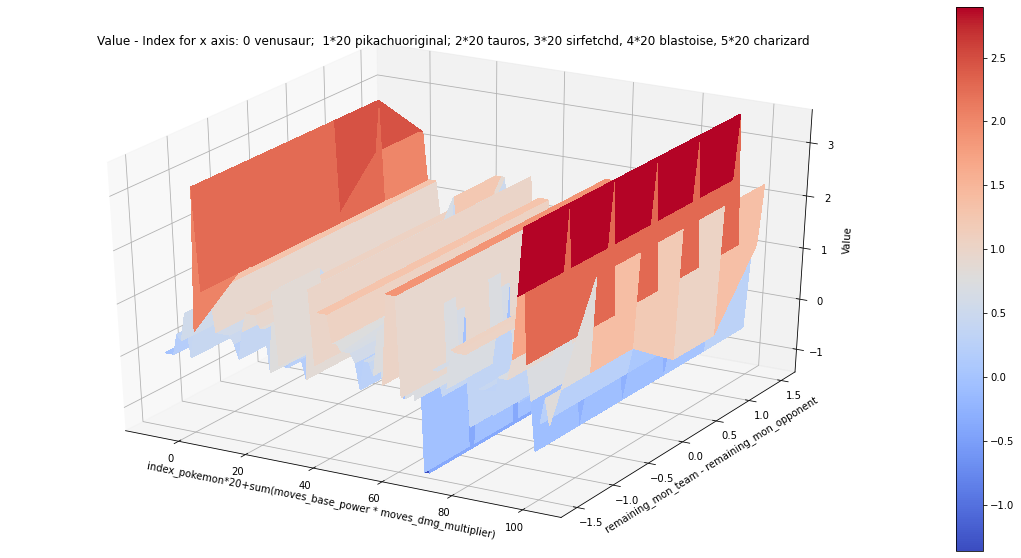

Q_QLearning_20211030_n_battles_40000_N0_0001_gamma_075_wining_4489.json


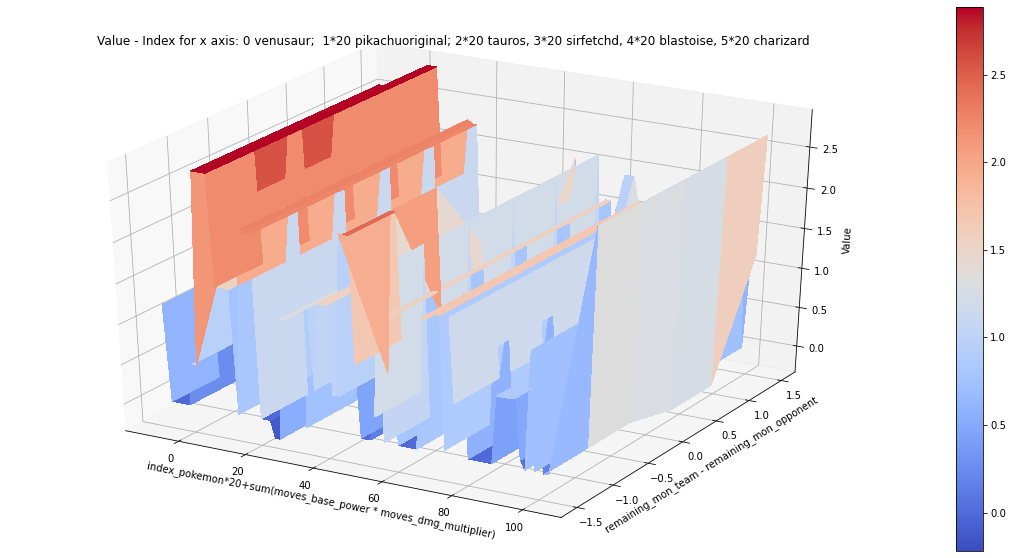

Q_QLearning_20211030_n_battles_40000_N0_001_gamma_075_wining_4605.json


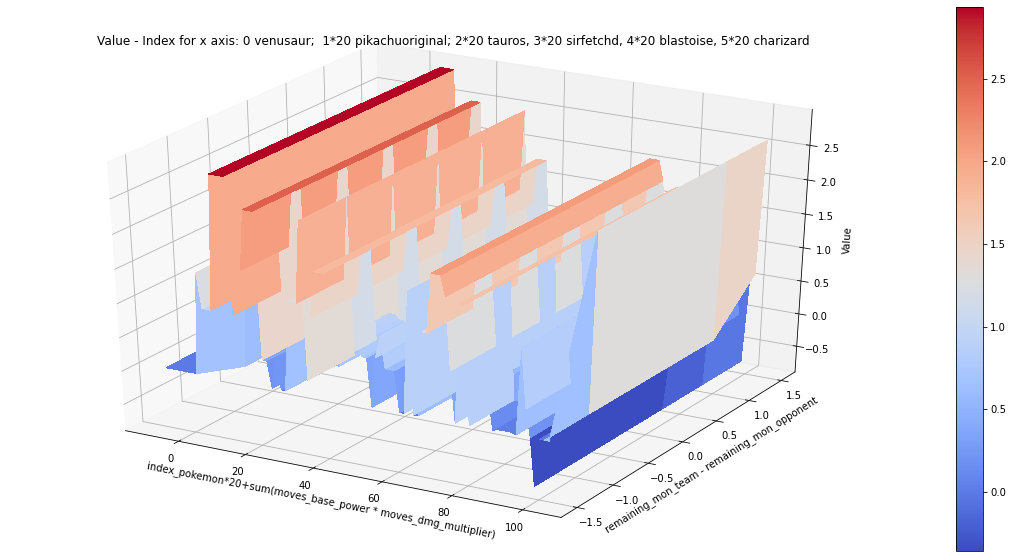

In [27]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - Index for x axis: 0 venusaur;  1*20 pikachuoriginal; 2*20 tauros, 3*20 sirfetchd, 4*20 blastoise, 5*20 charizard')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)

    plt.show()


In [28]:
# Data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0
v_array = []
#for test in tests:
directoryQ = r'S:\poke_env\dump\211029_40k\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #print(Qjson)
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    #test["vfunction"] = (x_values, y_values, z_values)
    v_array.append((x_values, y_values, z_values))
#plot_value_function(V, title="Optimal Value Function")

Q_QLearning_20211030_n_battles_40000_N0_00001_gamma_075_wining_427.json


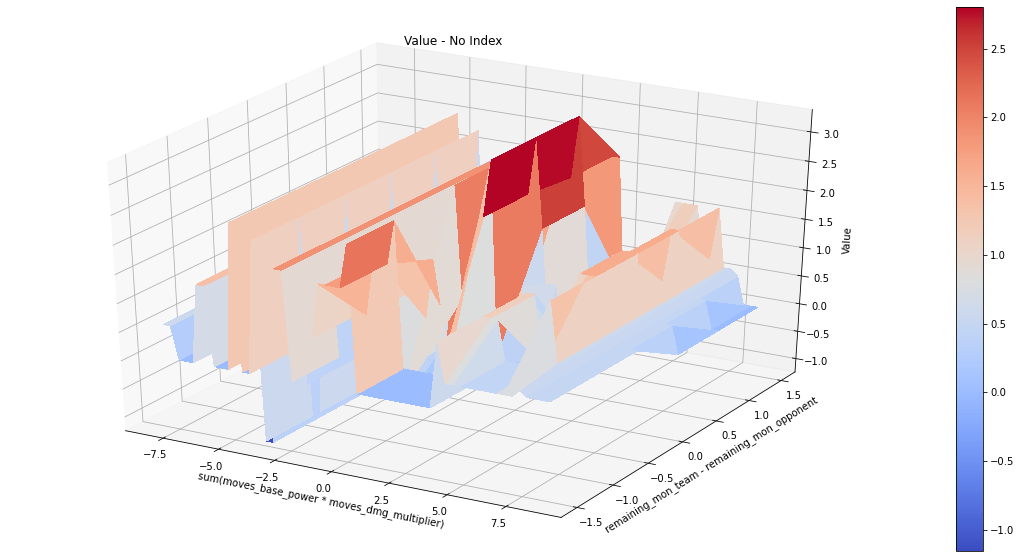

Q_QLearning_20211030_n_battles_40000_N0_0001_gamma_075_wining_4489.json


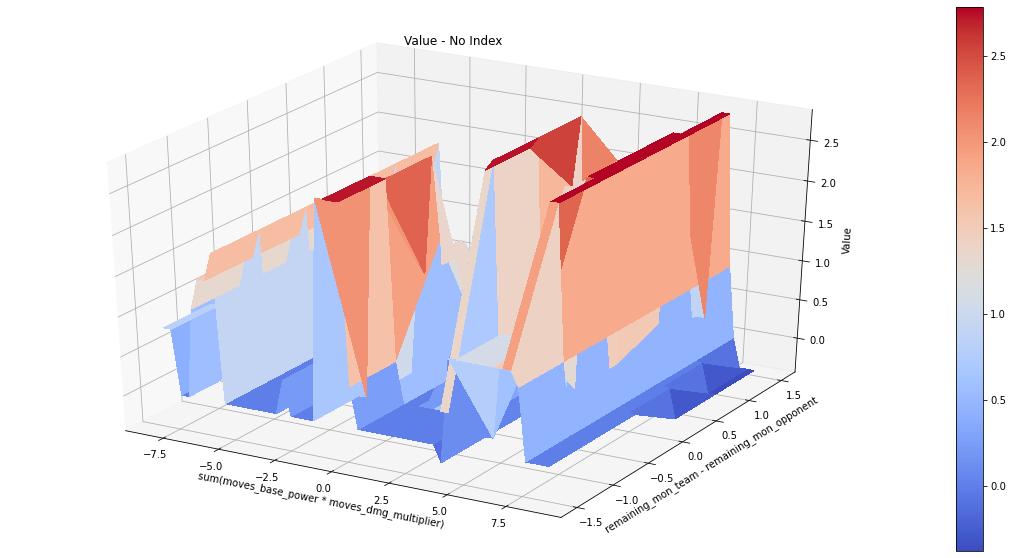

Q_QLearning_20211030_n_battles_40000_N0_001_gamma_075_wining_4605.json


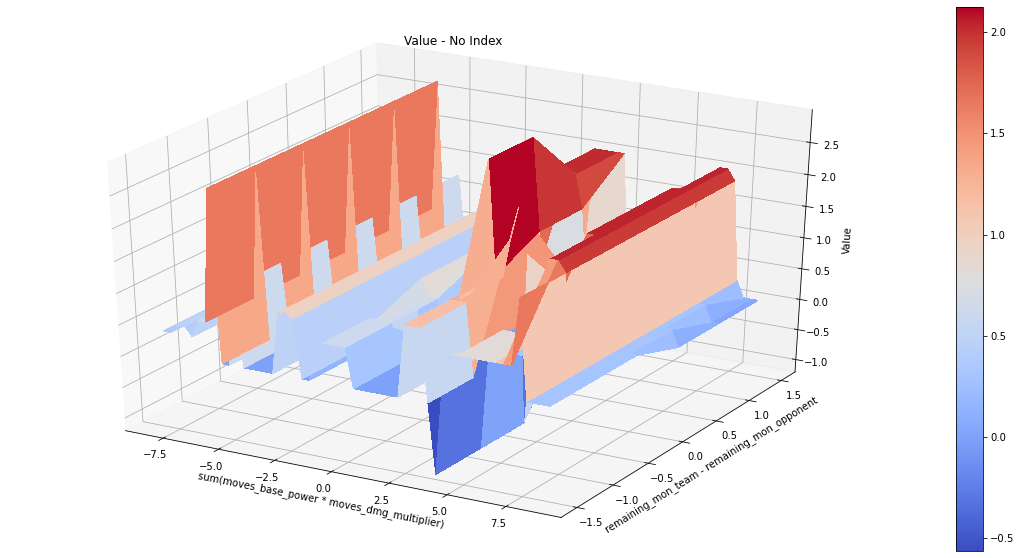

In [29]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - No Index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)

    plt.show()

In [30]:
V = defaultdict(float)
i = 0

v_array = []
#for test in tests:
directoryQ = r'S:\poke_env\dump\211029_40k\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #print(Qjson)
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items(): 
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = (key_float[8]-key_float[9])*(key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8])
        x_values.append(x_emb)
        y_emb = np.argmax(actions)
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

Q_QLearning_20211030_n_battles_40000_N0_00001_gamma_075_wining_427.json


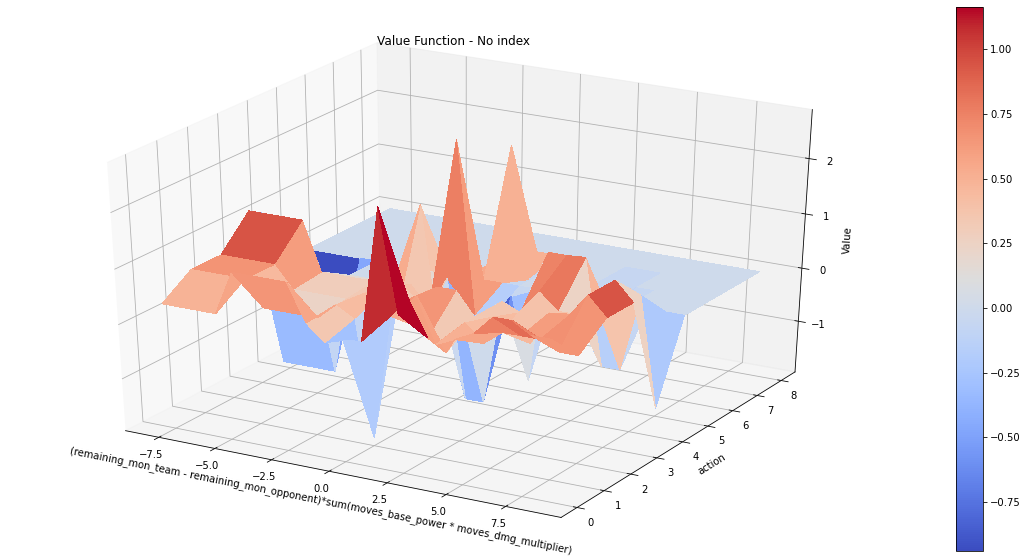

Q_QLearning_20211030_n_battles_40000_N0_0001_gamma_075_wining_4489.json


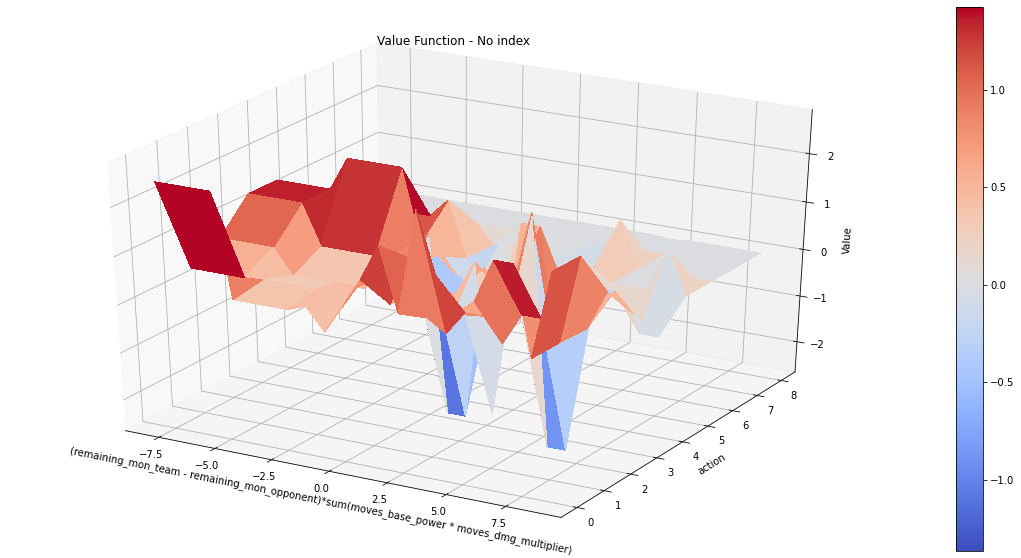

Q_QLearning_20211030_n_battles_40000_N0_001_gamma_075_wining_4605.json


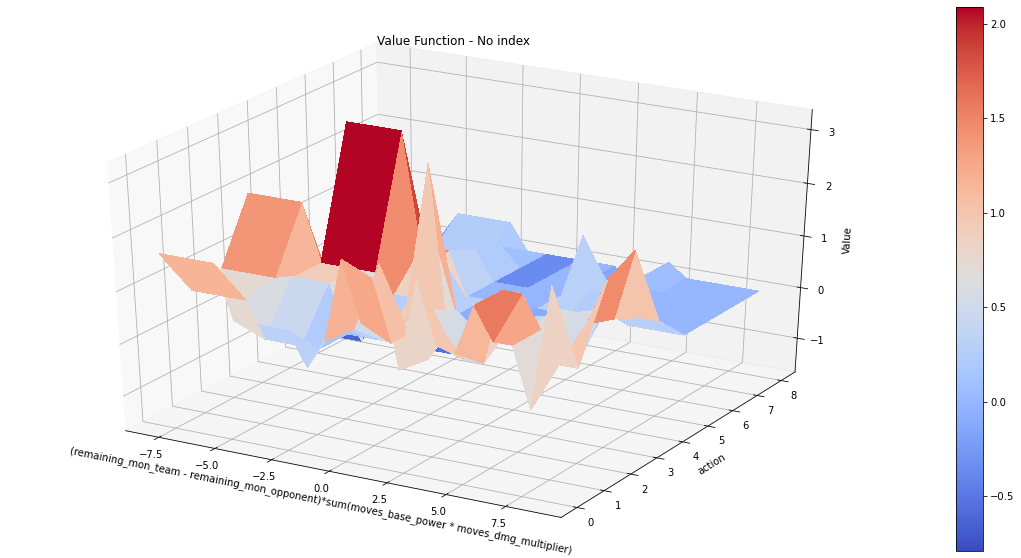

In [31]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('(remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('action')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    
    plt.show()    

In [15]:
#test['player'].Q.items()

In [16]:
#state, actions = next(iter(test['player'].Q.items()))


In [17]:
#actions

In [18]:
#for test in tests:
#    print("N0: ",test["n0"], " gamma: ", test["gamma"]," desv: ", np.array(test["vfunction"][2]).std(), " acc: ", test['player'].n_won_battles)#
#
#    print("wonn:", test['player'].n_won_battles)
#    print("V: ", test["vfunction"][2],"\n")

In [23]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for test in tests:
    if(test['player_val'].n_won_battles>0): #np.array(test["vfunction"][2]).std()>3e-16
        print(np.array(test["vfunction"][2]).sum())
        
        print("N0: ",test["n0"], " gamma: ", test["gamma"]," desv: ", np.array(test["vfunction"][2]).std(), " acc: ", test['player_val'].n_won_battles)
        x_values, y_values, z_values = test["vfunction"] 
        z_plot = np.array(z_values).reshape(len(z_values),1)
        x_plot = np.array(x_values)
        y_plot = np.array(y_values)
        xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
        df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
        x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
        y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
        x2, y2 = np.meshgrid(x1, y1)
        z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

        fig = plt.figure(figsize=(20, 10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
        ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
        ax.set_zlabel('Value')
        ax.set_title('Value - Index for x axis: 0 venusaur;  1*20 pikachuoriginal; 2*20 tauros, 3*20 sirfetchd, 4*20 blastoise, 5*20 charizard')

        surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
            linewidth=0, antialiased=False)
        fig.colorbar(surf)

        plt.show()

AttributeError: module 'scipy.special.orthogonal' has no attribute '__all__'

In [ ]:
# sem index - data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0

for test in tests:
    z_values = []
    x_values = []
    y_values = []
    for state, actions in test['player_val'].Q.items():
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    test["noindex_function"] = (x_values, y_values, z_values)
#plot_value_function(V, title="Optimal Value Function")

In [ ]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for test in tests:
    print(np.array(test["vfunction"][2]).sum())
        
    print("N0: ",test["n0"], " gamma: ", test["gamma"]," desv: ", np.array(test["vfunction"][2]).std(), " acc: ", test['player_val'].n_won_battles)
        
    x_values, y_values, z_values = test["noindex_function"] 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    
    plt.show()

In [ ]:
# sem index - data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0

for test in tests:
    z_values = []
    x_values = []
    y_values = []
    for state, actions in test['player_val'].Q.items():
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = (key_float[8]-key_float[9])*(key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8])
        x_values.append(x_emb)
        y_emb = np.argmax(actions)
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    test["noindex_function"] = (x_values, y_values, z_values)
#plot_value_function(V, title="Optimal Value Function")

In [ ]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for test in tests:
    print(np.array(test["vfunction"][2]).sum())
        
    print("N0: ",test["n0"], " gamma: ", test["gamma"]," desv: ", np.array(test["vfunction"][2]).std(), " acc: ", test['player_val'].n_won_battles)
        
    x_values, y_values, z_values = test["noindex_function"] 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('(remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('action')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    
    plt.show()

In [ ]:
# Too slow and i think is not correct
"""
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
xv, yv = np.meshgrid(x_plot, y_plot)
surf = ax.plot_surface(xv, yv, z_plot, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, 
                                antialiased=False)
ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
ax.set_zlabel('Value')
ax.set_title('Value Function')
fig.colorbar(surf)
plt.show()
"""

In [ ]:
#plot_value_function(V, title="Optimal Value Function")

In [ ]:
# Verify policy. Have to change the observation of Q and N
#print("Q: ", env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#print("N: ", env_player.N['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#greedy_action = np.argmax(env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#dim=env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'].shape
#observation = '0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'
#env_player.N[observation]
#ep = (0.1/(0.1+np.sum(env_player.N[observation])))
#probs = np.full(dim, ep / dim[0])
#probs
#greedy_action = np.argmax(env_player.Q[observation])
#probs[greedy_action] += 1 - (0.1/(0.1+np.sum(env_player.N[observation]))) 
#print(probs)
#print(env_player.policy(observation))


In [ ]:
# Methods for deterministic player (we have to define teams and perform team preview)

# We evaluate the performance on mon_a against mon_b as its type advantage
    def teampreview_performance(self, mon_a, mon_b):    
        a_on_b = b_on_a = -np.inf
        for type_ in mon_a.types:
            if type_:
                a_on_b = max(a_on_b, type_.damage_multiplier(*mon_b.types))
        # We do the same for mon_b over mon_a
        for type_ in mon_b.types:
            if type_:
                b_on_a = max(b_on_a, type_.damage_multiplier(*mon_a.types))
        # Our performance metric is the different between the two
        return a_on_b - b_on_a    
    
    # Teampreview (Before battle starts)
    def teampreview(self, battle):
        mon_performance = {}

        # For each of our pokemons
        for i, mon in enumerate(battle.team.values()):
            # We store their average performance against the opponent team
            mon_performance[i] = np.mean(
                [
                    self.teampreview_performance(mon, opp)
                    for opp in battle.opponent_team.values()
                ]
            )

        # We sort our mons by performance
        ordered_mons = sorted(mon_performance, key=lambda k: -mon_performance[k])

        # We start with the one we consider best overall
        # We use i + 1 as python indexes start from 0
        #  but showdown's indexes start from 1
        return "/team " + "".join([str(i + 1) for i in ordered_mons])

2021-10-20 22:16:20,618 - MaxDamagePlayer 1 - WARNING - Trying to login as MaxDamagePlayer 1, showdown returned  MaxDamagePlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException------

2021-10-20 22:46:20,593 - MaxDamagePlayer 4 - WARNING - Trying to login as MaxDamagePlayer 4, showdown returned  MaxDamagePlayer 4@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException------

2021-10-20 22:46:20,664 - MaxDamagePlayer 5 - WARNING - Trying to login as MaxDamagePlayer 5, showdown returned  MaxDamagePlayer 5@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException------